In [1]:
import laspy as lp
import numpy as np
import matplotlib.pyplot as plt


def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)

In [2]:
DATE = 250329
POZA = 'km11'
PATH_LAS = f'data/{DATE}_100m_7ms_100khz_plena_luz/pozas/{POZA}_100m_7ms_100khz_plena-luz_0_0.las' 

LIMIT = -1

rasantes = {
    'km11': 2300.382,  
    'km12': 2300.345,   
    'km13': 2300.372,
    '3a': 2300.305,
    '2a': 2300.700,
    'pam2': 2300.618  
}

salmueras = {
    'km11': 2300.866,
    'km12': 2300.582,
    'km13': 2300.647,
    'pam2': 2302.185,
    '2a': 2301.129,
    '3a': 2300.978
}

rasante = rasantes.get(POZA, None)
c_salmuera = salmueras.get(POZA, None)

In [3]:
from pyproj import CRS
las = read_las_file(PATH_LAS)

points = np.vstack((las.x, las.y, las.z)).transpose()
data_points = np.hstack((points,
                        np.expand_dims(las.return_number, -1),
                        np.expand_dims(las.number_of_returns, -1)))

print(f'{POZA}')

first = data_points[(data_points[:,-2] == 1) & (data_points[:,-1] == 2)][:, :3]
salmuera = np.mean(first[:,2])
print(f'Cota Salmuera: {salmuera}')

one_return = data_points[(data_points[:, -1] == 1)][:, :3]
one_return = one_return[one_return[:,2] >= rasante]  # remove noise
#one_return = one_return[one_return[:,2] <= salmuera] # con la salmuera detectada por el lidar
one_return = one_return[one_return[:,2] <= c_salmuera] # con la salmuera dada por sqm

first_bottom = first[first[:,2] <= c_salmuera]
one_return = np.vstack((one_return, first_bottom))

print(f'Cota Sal Promedio: {np.mean(one_return[:,2])}')



km11
Cota Salmuera: 2301.1397392027266
Cota Sal Promedio: 2300.624071988173


In [5]:
import numpy as np
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator
import rasterio
from rasterio.transform import from_origin

INTERPOLACION = 'linear'

x, y, z = one_return[:,0], one_return[:,1], one_return[:,2] - rasante

# 3. Calcular espaciado automático 
point_spacing = np.mean(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
grid_spacing = point_spacing * 1.5
print(f'Resolución del DEM: {grid_spacing} m')

# 4. Crear cuadrícula
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

cols = int(np.ceil((x_max - x_min) / grid_spacing))
rows = int(np.ceil((y_max - y_min) / grid_spacing))

# 5. Binning para promedio
grid_sum = np.zeros((rows, cols))
grid_count = np.zeros((rows, cols))

xi = ((x - x_min) / grid_spacing).astype(int)
yi = ((y_max - y) / grid_spacing).astype(int)

np.add.at(grid_sum, (yi, xi), z)
np.add.at(grid_count, (yi, xi), 1)

dem = np.divide(grid_sum, grid_count, where=grid_count != 0)
dem[grid_count == 0] = np.nan

# --- Interpolación para huecos ---
mask = ~np.isnan(dem)
y_coords, x_coords = np.where(mask)

xx = x_min + (x_coords + 0.5) * grid_spacing
yy = y_max - (y_coords + 0.5) * grid_spacing

# Selección del método de interpolación
if INTERPOLACION == 'nearest':
    interpolator = NearestNDInterpolator(list(zip(xx, yy)), dem[mask])
elif INTERPOLACION == 'linear':
    interpolator = LinearNDInterpolator(list(zip(xx, yy)), dem[mask])
else:
    raise ValueError("Método de interpolación no válido. Usar 'nearest' o 'linear'")

grid_x, grid_y = np.meshgrid(
    x_min + (np.arange(cols) + 0.5) * grid_spacing,
    y_max - (np.arange(rows) + 0.5) * grid_spacing
)

dem_filled = dem.copy()
nan_mask = np.isnan(dem)
dem_filled[nan_mask] = interpolator(grid_x[nan_mask], grid_y[nan_mask])

# Manejo de NaN residuales (opcional)
if INTERPOLACION == 'linear' and np.isnan(dem_filled).any():
    print("Advertencia: La interpolación lineal dejó valores NaN. Rellenando con nearest.")
    interpolator_respaldo = NearestNDInterpolator(list(zip(xx, yy)), dem[mask])
    dem_filled[np.isnan(dem_filled)] = interpolator_respaldo(
        grid_x[np.isnan(dem_filled)], 
        grid_y[np.isnan(dem_filled)]
    )
# 7. Guardar el DEM interpolado
transform = from_origin(
    x_min - grid_spacing/2, 
    y_max + grid_spacing/2, 
    grid_spacing, 
    grid_spacing
)

with rasterio.open(
    f"dems/{POZA}.tiff",
    'w',
    driver='GTiff',
    height=rows,
    width=cols,
    count=1,
    dtype=dem_filled.dtype,
    crs=None,
    transform=transform,
) as dst:
    dst.write(dem_filled, 1)

print("DEM con interpolación nearest generado!")

Resolución del DEM: 0.2899320303176885 m
Advertencia: La interpolación lineal dejó valores NaN. Rellenando con nearest.
DEM con interpolación nearest generado!


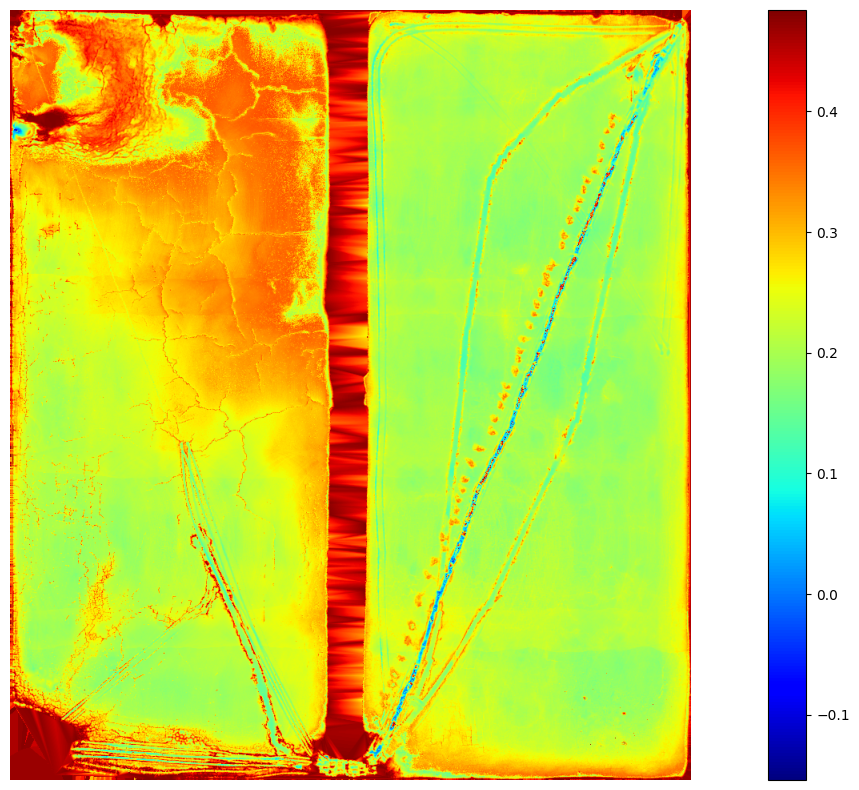

(963, 851)

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(dem_filled, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()
dem.shape


Number of bands: 1
Width: 235
Height: 316
CRS: None
Transform: 
| 0.30, 0.00, 558845.28|
| 0.00,-0.30, 7394824.88|
| 0.00, 0.00, 1.00|
Data type: float64


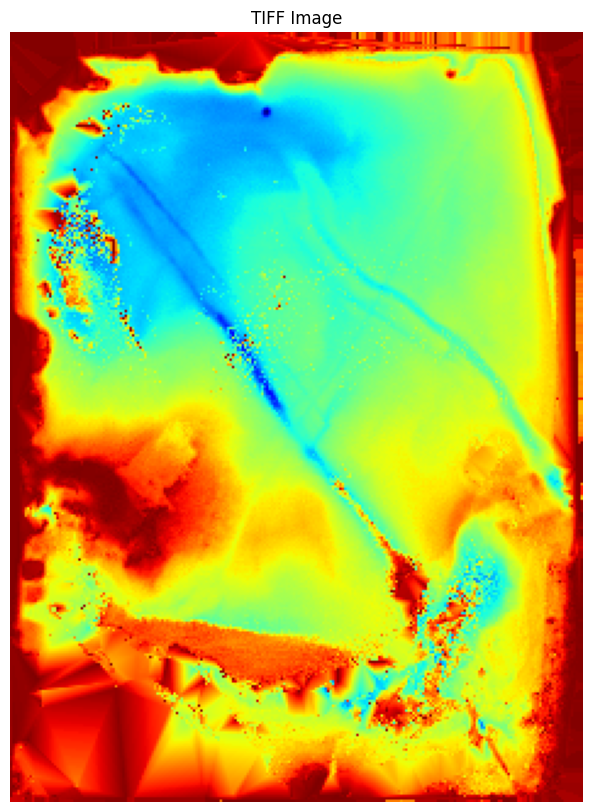

In [7]:
import rasterio
import matplotlib.pyplot as plt

POZA = 'pam2'
tiff_path = f'dems/{POZA}.tiff'

with rasterio.open(tiff_path) as src:
    data = src.read()
    
    # Print basic information about the raster
    print(f'Number of bands: {src.count}')
    print(f'Width: {src.width}')
    print(f'Height: {src.height}')
    print(f'CRS: {src.crs}')
    print(f'Transform: \n{src.transform}')
    print(f'Data type: {src.dtypes[0]}')

    # Display the image
    if src.count == 1:
        plt.figure(figsize=(20,10))
        plt.imshow(data[0], cmap='jet')
    else:
        plt.imshow(data.transpose(1, 2, 0))

    plt.title('TIFF Image')
    plt.axis('off') 
    plt.show()